# chainerの練習

$y=e^x$ という関数をいわゆるディープラーニングで学習してみましょう。

まず必要なモジュール類をインポートします。

In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

from matplotlib import pyplot as plt
%matplotlib inline

まず教師データを出力する関数を作ります。バッチ学習という手法を使うので、
$n$ 個の問題・解答のセットを返す関数があると便利です。今回は0から1.0までの浮動小数$x$に対して$e^x$が期待値です。

In [2]:
def get_batch(n):
    x=np.random.random(n)
    y= np.exp(x)
    return x,y

In [3]:
print get_batch(2)

(array([ 0.20592995,  0.82926627]), array([ 1.22866713,  2.29163667]))


次に、ネットを作ります。

$y=e^x$ は非線形関数なので、線形関数だけでの近似では十分な精度が得られません。
入力を$x$としたとき、$y=Wx+b$のようなものを線形関数と呼びます。$W$を重み、$b$をバイアスと呼びますが、どちらもただの行列です。$x$に対する一次式なわけなのでつまり直線ですね。

さて、この線形演算に対して、
非線形関数による活性化層が入るだけでもうニューラルネットと呼んでいいらしいです。
それを多層にしたものがディープニューラルネット、いわゆるディープラーニングで使われる非線形関数（のようなもの）です。どれぐらい深ければディープと呼んでいいのか不明ですが、今回は3段ぐらいにしてみます。

一般的な分類問題だとreluという非線形関数が非常によく使われますが、
reluだと微分消失してしまうので今回はleaky_reluを使います（この問題の場合はreluだとちっとも収束しません）。

というわけで、構成は下記のようにしてみます。L1,L2,L3はそれぞれ線形関数で、その後にleaky_reluという関数が入っています。入力が負なら0.2をかける、というだけの関数です。いったん中間層の次元が16->32と増したあとに、最後に1次元の値を出力します。

<img src="chainer_00.png">

これをchainerで書き下します。

chainerでは、最適化されるべきパラメータを持つ関数をL(リンク)、パラメータなしの関数をF(ファンクション)と呼んで区別しています。このあたりはver1.5から導入された概念だそうで、リンクをファンクションで書いたりしているチュートリアルをよく見かけます。リンクはL.Linear(入力サイズ,出力サイズ)のように大文字始まりで、
ファンクションはF.linear(x,W,b)のように小文字始まりで定義されています。古いバージョンでは大文字始まりのファンクションが使われていたようで、F.LinearとL.LinearとF.linearがありますが、前者２つは等価のようです。私はこのあたり理解するまでにだいぶ混乱しました。

話がそれました。リンクをまとめたものを渡してチェインと呼ばれるクラスを作ります。
Pythonのクラスの書き方に慣れていないと面食らいますが、リンク一覧を定義する\_\_init\_\_()と
出力までの計算グラフを返す関数だけがあれば良いです。ここではロスを\_\_cal\_\_()で返す
ことにします。\_\_call\_\_()で定義した関数は 
```
m=MyChain()
loss=m(x,t)
```
のように呼べます。

パラメータを含む関数は\_\_init\_\_()に、それ以外は\_\_call()\_\_や他のメソッドで使うように
切り分けられているのがポイントですね。

L.Linear()は入力チャネル、出力チャネル、の数だけをパラメータで渡せばいいのでTensorflowよりはるかに記述は簡単です。

In [4]:
class MyChain(Chain):
    def __init__(self):
        super(MyChain, self).__init__(
             l1=L.Linear(1, 16),
             l2=L.Linear(16, 32),
             l3=L.Linear(32, 1),
        )

    def __call__(self,x,t):
        # xを入力した際のネットワーク出力と、回答t との差分を返します。
        # 今回は最小二乗を使います。
        return F.mean_squared_error(self.predict(x),t)

    def  predict(self,x):
        # xを入力した際のネットワーク出力を返します。
        h1 = F.leaky_relu(self.l1(x))
        h2 = F.leaky_relu(self.l2(h1))
        h3 = F.leaky_relu(self.l3(h2))
        return h3

    def get(self,x):
        # xを実数で入力したら出力を実数で返すという便利関数です。
        # numpy.ndarrayとValiableを経由するのでいろいろわかりにくいです。
        return self.predict(Variable(np.array([x]).astype(np.float32).reshape(1,1))).data[0][0]

オプティマイザを定義します。なんでも良いのですがAdam()というのを使います。

In [5]:
model = MyChain()
optimizer = optimizers.Adam()
optimizer.setup(model)

いよいよ学習ループを回します。

chainerの作法として、(バッチ軸, データ軸1,(データ軸2),..)という次元構造を持つ np.float32 の配列（テンソル）をVariableクラスに変換したものでやりとりします。Variableクラスから数値の実体を取り出すには dataメソッドを使います。

この場合は入力データが1次元なので、
  (バッチ軸、データ軸）
で良いですが、2次元画像のRGB３チャネルで構成されるデータは
  (バッチ軸、色軸、縦軸、横軸）
のように渡します。この辺も慣れないとわかりにくいですね。

学習のアップデートは
 
 1. zerograds（微分の初期化）
 2. forward（この場合はlossfun) 
 3. backword （ネットを逆向きに辿ってパラメータの微分を計算する。バックプロパゲーション）
 4. オプティマイザのupdate
 
が一連の流れです。optimizer.update(model) でこの流れを一気にやってくれますが、どうせforwardの途中経過を覗きたくなるので、私は下記のようにすべて書くことが多いです。

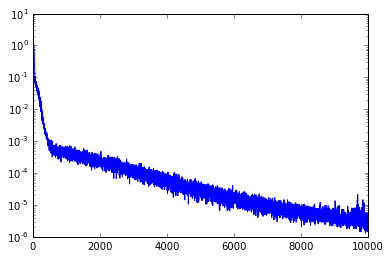

In [6]:
losses =[]
for i in range(10000):
    x,y = get_batch(100)
    x_ = Variable(x.astype(np.float32).reshape(100,1))
    t_ = Variable(y.astype(np.float32).reshape(100,1))
    
    model.zerograds()
    loss=model(x_,t_)
    losses.append(loss.data)
    loss.backward()
    optimizer.update()

plt.plot(losses)
plt.yscale('log')


横軸はループ回数、縦軸はlossをlogプロットしたものです。いい感じに減ってますね。

では、出来上がったモデルの出力を確認してみましょう。0.2を入れたらexp(0.2)に近い値が出るでしょうか。

In [7]:
print model.get(0.2)
print np.exp(0.2)

1.22218
1.22140275816


良さそうですね。では0から1の範囲でどれ位関数フィットできているでしょうか。

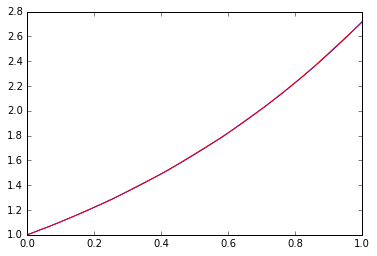

In [8]:
x=np.linspace(0,1,100)
plt.plot(x,np.exp(x))
plt.hold(True)
p=model.predict(Variable(x.astype(np.float32).reshape(100,1))).data
_=plt.plot(x, p,"r")

青が正解で、赤が学習結果です。

そこそこいい感じです。線形関数というのは直線なので、線形関数だけではこのフィット性能は出ませんよね。
ネットの深さ、幅（次元数）、などをいろいろ変えてみると面白いですが、よく言われているように、
幅よりも非線形要素と深さが重要、というのが確認できます。

さて、結果学習後のモデルはどういう係数でできているのか見てみましょう。
たとえば最初のレイヤl1の重み$W$は下記のようにしてアクセスできます。

In [9]:
model.l1.W.data

array([[ 0.09820887],
       [-0.17221999],
       [ 1.17115438],
       [-1.18256056],
       [-1.11487651],
       [-0.2901957 ],
       [ 0.67553222],
       [ 2.1718173 ],
       [-0.24854074],
       [-0.0388921 ],
       [-0.44927156],
       [ 0.35599843],
       [ 0.90996617],
       [-0.08619885],
       [ 0.91230369],
       [-1.18955493]], dtype=float32)

これらをそのまま書き下すと、たとえば下記のようなnumpyだけで同じ出力を出す関数を作れます。
（収束ごとに値は違いますので注意です）。CやGoなどの言語へ変換するのも難しくはないと思います（numpyは十分速いと思いますが）。

In [10]:
def leaky_relu(x):
    # 要素ごとの演算にするために一度ndarrayを経由する
    m=np.array((x<0))
    x=np.array(x)
    return np.matrix((x*0.2)*m + x*(~m)) 

def pseudo_exp(x):
    x=np.matrix(x)
    W1=np.matrix([[-1.42460084],
       [-0.49742168],
       [-0.70745921],
       [ 1.37859845],
       [ 0.08068201],
       [-0.54294825],
       [ 1.86289704],
       [-0.49926493],
       [ 0.54737771],
       [ 0.26142526],
       [-1.87905848],
       [-1.48717654],
       [-1.13108552],
       [-0.23480603],
       [-1.75705421],
       [ 0.90751594]])
    b1 = np.matrix([ -1.42988155e-03,  -4.14132082e-05,  -2.05025333e-03,
         3.33620496e-02,   3.07750870e-02,   3.21100056e-01,
        -5.28228022e-02,   4.03331310e-01,   3.92777510e-02,
        -1.14495240e-01,  -2.98100878e-02,  -6.71487214e-05,
        -2.27367622e-04,  -2.03698911e-02,  -2.70254258e-02,
        -1.93924218e-01])
    W2=np.matrix([[ 0.04201862,  0.06239045,  0.06002109, -0.3963882 , -0.23172154,
        -0.29611194, -0.51568294, -0.26809564,  0.03698349, -0.40606719,
         0.16199832, -0.37547034, -0.17982063, -0.1968637 ,  0.45786461,
         0.27663031],
       [-0.17504245, -0.20876755,  0.34555602,  0.17325753,  0.24915171,
        -0.19210783, -0.24184623, -0.5062061 , -0.14681788,  0.02308536,
         0.21849304,  0.3938958 ,  0.46440542,  0.10369529,  0.05717859,
        -0.01657704],
       [ 0.22795291, -0.22703589,  0.02942969,  0.01103536, -0.52398854,
        -0.53581524,  0.46951666, -0.79210472, -0.08658655,  0.16943403,
        -0.27268144, -0.17947534, -0.28112483, -0.02069088,  0.18276712,
         0.81583017],
       [-0.33497253,  0.00894715,  0.19387256,  0.0933296 ,  0.24417046,
        -0.01682332,  0.32200241,  0.720743  ,  0.01538747, -0.10538575,
        -0.88943529,  0.14247324, -0.53050333,  0.01704734, -0.0412376 ,
         0.18736191],
       [ 0.24731554,  0.19900818, -0.17335226,  0.45811296,  0.31148031,
         0.15853061, -0.11907062,  0.40448606, -0.1624583 , -0.38740286,
        -0.42159331, -0.00354848, -0.03251942, -0.37650371, -0.1202684 ,
        -0.10700542],
       [-0.23688065, -0.24158652, -0.15376922, -0.01959478,  0.13606754,
        -0.18131319, -0.24875179,  0.21144329, -0.03676015,  0.24516439,
         0.10191762,  0.14041337, -0.26004726, -0.20982297,  0.30226669,
        -0.10783092],
       [ 0.05611663, -0.04433119,  0.02099903,  0.14060682, -0.00244093,
         0.7671935 ,  0.01328119,  0.41018867,  0.26956582, -0.00196901,
        -0.37450302, -0.06384661,  0.12857398, -0.24205625, -0.0108219 ,
         0.24342601],
       [ 0.20457916,  0.04821841,  0.20885691, -0.53413606, -0.38362995,
        -0.20944035,  0.09541608, -0.04838281,  0.07115572, -0.83593577,
        -0.25069809,  0.32358333,  0.15969384, -0.09560774, -0.23514238,
         0.50624079],
       [-0.45446488,  0.01702037, -0.06464836, -0.05362793, -0.12767524,
         0.21191528, -0.1271926 ,  0.63526595,  0.05451211,  0.36766076,
        -0.0667036 , -0.15183701,  0.03701701, -0.72655195, -0.27899286,
         0.38405734],
       [ 0.03836586,  0.0719102 ,  0.20157301, -0.28952029, -0.21952201,
        -0.66136789, -0.10179753, -0.03392251,  0.27940056, -0.58329397,
         0.15621631, -0.17979205,  0.20549315,  0.27336398,  0.18447515,
        -0.03689834],
       [-0.25301   ,  0.1412034 ,  0.17842141, -0.05297476,  0.02991281,
         0.56754005,  0.17688522,  0.50712383,  0.21447131,  0.48208299,
        -0.40115827,  0.08683142, -0.34969404,  0.02097755, -0.12347813,
         0.44567949],
       [ 0.07149724, -0.03292188,  0.19176833,  0.44523722,  0.42945331,
         0.28428334, -0.16431747,  0.32320473,  0.25221846,  0.33074671,
        -0.00258682, -0.44721836,  0.01618218,  0.03884149, -0.10509065,
         0.05047898],
       [ 0.17070144, -0.28707293, -0.11286955,  0.27923238, -0.21279278,
         0.23367143, -0.15942864,  0.18774372,  0.2345082 ,  0.20511211,
        -0.59546071,  0.11335401,  0.01974677, -0.31659463,  0.0275536 ,
        -0.02532974],
       [ 0.26584402,  0.21306798,  0.24790715, -0.10889802, -0.19633293,
        -0.6545521 , -0.26156977, -0.18439284, -0.35518405, -0.21354887,
         0.31463626,  0.04141026, -0.06428859,  0.11319346, -0.20376451,
        -0.15062912],
       [ 0.25042129,  0.05784211, -0.03993187, -0.10700491, -0.23057345,
        -0.10544498,  0.46927556,  0.07808451,  0.24642093, -0.00553552,
         0.02552916, -0.03878186,  0.02121772,  0.26880464, -0.02680874,
        -0.02686586],
       [ 0.26578343, -0.19567609, -0.1743964 , -0.40052289, -0.14417978,
        -0.13053447, -0.10923278, -0.34931764,  0.04118302, -0.48277548,
        -0.60311139, -0.0967597 ,  0.06876933,  0.16050538,  0.16660455,
        -0.18794402],
       [-0.5717333 ,  0.12032515, -0.07840737,  0.31402567,  0.26411948,
         0.75332034, -0.02453594,  0.39534694, -0.05797524, -0.2688373 ,
        -0.1485081 , -0.30828241, -0.10139723,  0.14400557, -0.16382544,
        -0.11648156],
       [-0.15560001, -0.18490978, -0.01891642,  0.3302418 , -0.43163413,
        -0.52363211, -0.07780209, -0.15345493, -0.39440861, -0.21726708,
        -0.11295689,  0.04707107,  0.47606313,  0.02102779, -0.08384705,
        -0.17889649],
       [ 0.12520151,  0.32024959,  0.43869781,  0.09339513, -0.1274506 ,
        -0.22625796,  0.15776135, -0.11968201, -0.04883307, -0.18061049,
         0.17592409,  0.14072709, -0.237028  ,  0.54556167,  0.22367503,
        -0.3602013 ],
       [-0.13104168, -0.29190183,  0.12917598, -0.05329958, -0.04826533,
         0.16049559,  0.2012606 ,  0.6034736 ,  0.40502071,  0.01538516,
         0.11730529,  0.38719073, -0.40056983, -0.47716457,  0.29893357,
         0.34792182],
       [-0.04633478, -0.29538393, -0.19095849, -0.23338833,  0.27714857,
        -0.22695932, -0.36205661,  0.24944146, -0.00615353, -0.13379772,
         0.02319622, -0.21428259,  0.59764332,  0.21060616,  0.45666307,
         0.19196714],
       [-0.22256424,  0.41685557,  0.23898984, -0.17066558, -0.12960611,
         0.15313114, -0.49082202, -0.4444384 ,  0.727606  , -0.11430718,
        -0.0861064 , -0.03297592,  0.46448919,  0.20688777,  0.16872981,
        -0.09959562],
       [ 0.12956351, -0.31909686, -0.18492132, -0.30969712, -0.03124504,
        -0.03244626, -0.24354014, -0.4472402 , -0.15015699, -0.11988792,
         0.18080382,  0.18706131,  0.1432811 ,  0.27109849, -0.03745826,
        -0.12332518],
       [ 0.09568503, -0.07294741,  0.15673868,  0.18610375, -0.39143902,
         0.26086026, -0.05705253,  0.20155145,  0.31820562, -0.0017326 ,
         0.01827412, -0.41745037, -0.36750761, -0.1652623 , -0.0524752 ,
         0.02982271],
       [-0.02720707,  0.11063083,  0.13352096,  0.19816986, -0.44733983,
         0.82240474,  0.27483478,  0.49076113,  0.0473393 ,  0.7990489 ,
        -0.17097335,  0.55738169, -0.07784814, -0.34220502, -0.48683316,
        -0.18258347],
       [-0.28176978, -0.41825068,  0.21477231,  0.12954797,  0.00766978,
        -0.07561526, -0.29306114, -0.63858205, -0.47872946,  0.03739222,
        -0.14545698,  0.08877407,  0.31463778,  0.08558895, -0.08296563,
        -0.564767  ],
       [ 0.17791021,  0.38007465,  0.31627294, -0.07439342, -0.24402881,
         0.4388586 , -0.0321063 , -0.37122431, -0.22664541,  0.0011094 ,
        -0.12663779,  0.15388386, -0.11328371,  0.21764517,  0.45599172,
        -0.32432231],
       [-0.19202021, -0.23500964,  0.28798988, -0.0405061 , -0.32288179,
         0.46694198,  0.15857089,  0.15776642,  0.3390817 ,  0.02964408,
        -0.24913028,  0.21628296, -0.14530948, -0.10073123, -0.29420817,
         0.04539044],
       [ 0.27541462, -0.15237311,  0.11211757,  0.30618131,  0.42988917,
         0.02868037,  0.22027634,  0.20938079,  0.02443539,  0.1614583 ,
        -0.06873046, -0.11673749, -0.29116419, -0.12657058, -0.03635475,
         0.03986924],
       [-0.0166667 ,  0.08405428, -0.15716298,  0.49858654, -0.22415282,
         0.14821211,  0.2228734 ,  0.15578006, -0.28919947,  0.66504627,
        -0.49339563,  0.11867576, -0.08274963, -0.25817493, -0.2081929 ,
         0.19583215],
       [-0.46458748,  0.17724065,  0.15917888, -0.20438336,  0.01860778,
         0.12722245, -0.17972043, -0.16844292, -0.24367641, -0.24997567,
         0.21329767,  0.44737545, -0.01577723,  0.35331872, -0.28261596,
        -0.29502013],
       [-0.33424625, -0.08216175, -0.25327051,  0.22711514,  0.24427293,
         0.17207393, -0.14622162,  0.4152278 ,  0.71172541,  0.00916014,
        -0.24596159,  0.09187399, -0.02877321, -0.06661691, -0.12278015,
        -0.01383607]])
    b2 = np.matrix([-0.04099027, -0.03115051, -0.15900402,  0.03004   ,  0.04321276,
       -0.04245805,  0.02045222, -0.02403915,  0.01878707, -0.02718348,
       -0.06004241,  0.03900901,  0.04472733, -0.03960983,  0.01038494,
       -0.04110324,  0.01583585, -0.02707813, -0.02368152, -0.08569113,
       -0.04233929, -0.04145124,  0.02973141,  0.03821159,  0.0229961 ,
        0.0726597 , -0.04176667,  0.03488239,  0.04093761,  0.03678359,
       -0.04223128,  0.04129609])
    W3=np.matrix([[-0.26372328, -0.17967321,  0.09648963,  0.08401711,  0.36899596,
        -0.28630495,  0.16294025, -0.05505525,  0.30874005, -0.09988848,
         0.0794489 ,  0.26569751,  0.20759588, -0.2481029 , -0.12896538,
        -0.41550639,  0.1165776 , -0.03799086, -0.29893228,  0.05842109,
        -0.07389991, -0.3604964 , -0.05480177,  0.13593706,  0.14797091,
        -0.05037073, -0.30703464,  0.17116669,  0.23919608,  0.09978604,
        -0.4746612 ,  0.51076305]])
    b3=np.matrix([ 0.04305673])
    
    h1=leaky_relu(W1*x+b1.T)
    h2=leaky_relu(W2*h1+b2.T)
    h3=leaky_relu(W3*h2+b3.T)
    return h3

In [11]:
pseudo_exp(0.2)

matrix([[ 1.21904263]])

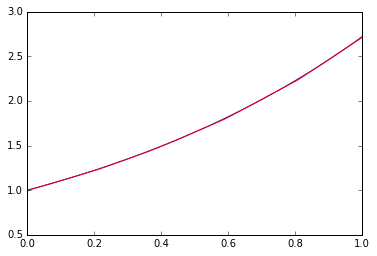

In [12]:
x=np.linspace(0,1,100)
plt.plot(x,np.exp(x))
plt.hold(True)
p=pseudo_exp(x.T)
_=plt.plot(x, p.T,"r")

chainerに依存しないpseudo_exp()が出来ました。